<a href="https://colab.research.google.com/github/mohammadashraf2004/Python-/blob/main/Plant%20Disease%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install kaggle

In [12]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!kaggle datasets download -d hsmcaju/d-kap

Dataset URL: https://www.kaggle.com/datasets/hsmcaju/d-kap
License(s): DbCL-1.0
d-kap.zip: Skipping, found more recently modified local copy (use --force to force download)


In [14]:
!ls

APPLE_DISEASE_DATASET  d-kap.zip  kaggle.json  sample_data


In [15]:
from zipfile import ZipFile
dataset = '/content/d-kap.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.model_selection import train_test_split

In [17]:
import tensorflow as tf

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/APPLE_DISEASE_DATASET",
    image_size=(224, 224),  # Specify the size to resize the images
    batch_size=32,           # Specify the batch size
    validation_split=0.2,    # Split the data for validation
    subset="both",           # Load both training and validation datasets
    seed=123                 # Seed for reproducibility
)

# Split the dataset
train_dataset = dataset[0]
val_dataset = dataset[1]


Found 419 files belonging to 4 classes.
Using 336 files for training.
Using 83 files for validation.


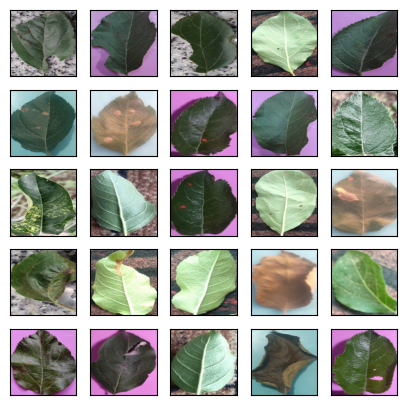

In [18]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training dataset
train_images, train_labels = next(iter(train_dataset))

plt.figure(figsize=(5, 5))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i] / 255.0)  # Normalize the images
plt.show()


In [39]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D
from keras.applications import MobileNet
from keras import regularizers
from keras.initializers import GlorotUniform
from keras.callbacks import EarlyStopping
from keras.layers import LeakyReLU
from keras.optimizers import Adam

# Define image size and input shape
img_size = 224  # Adjust based on your input size
input_shape = (img_size, img_size, 3)

# Load the MobileNet model without the top layers and with pre-trained weights
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Step 1: Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)

# Add additional layers
model.add(Flatten())
model.add(Dropout(0.7))
model.add(Dense(64, kernel_initializer=GlorotUniform(), kernel_regularizer=regularizers.l2(0.01)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.7))
model.add(Dense(4, activation='softmax', kernel_initializer=GlorotUniform()))  # Use softmax for multi-class classification

# Compile the model
initial_learning_rate = 0.01  # Set an initial learning rate
model.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 2: Train the model with frozen layers
h = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

# Step 3: Unfreeze one or two of the top hidden layers
# Unfreeze the last two layers
for layer in base_model.layers[-2:]:
    layer.trainable = True

# Reduce the learning rate when unfreezing layers
fine_tune_learning_rate = 0.0001  # Lower learning rate
model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Fine-tune the model
h_fine_tune = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[early_stopping])

# Summary of training results
print("Initial training results:", h.history)
print("Fine-tuning results:", h_fine_tune.history)



Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2719 - loss: 15.5753 - val_accuracy: 0.3855 - val_loss: 8.7390
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4280 - loss: 8.6271 - val_accuracy: 0.5783 - val_loss: 4.0731
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5274 - loss: 6.4935 - val_accuracy: 0.6386 - val_loss: 4.6304
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5973 - loss: 5.3279 - val_accuracy: 0.6145 - val_loss: 4.3696
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.6463 - loss: 4.8284 - val_accuracy: 0.5783 - val_loss: 5.4035
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7613 - loss: 4.5077 - val_accuracy: 0.6265 - val_loss: 5.7916
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7208 - loss: 4.7109 - val_accuracy: 0.6265 - val_loss: 5.7207
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6361 - loss: 5.4911 - val_accuracy: 0.5542 - val_loss

In [40]:
print("Evaluating model...")
scores = model.evaluate(val_dataset)  # or use test_dataset if available
print(f"Validation Accuracy: {scores[-1] * 100:.2f}%")


Evaluating model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5924 - loss: 2.9902
Validation Accuracy: 61.45%


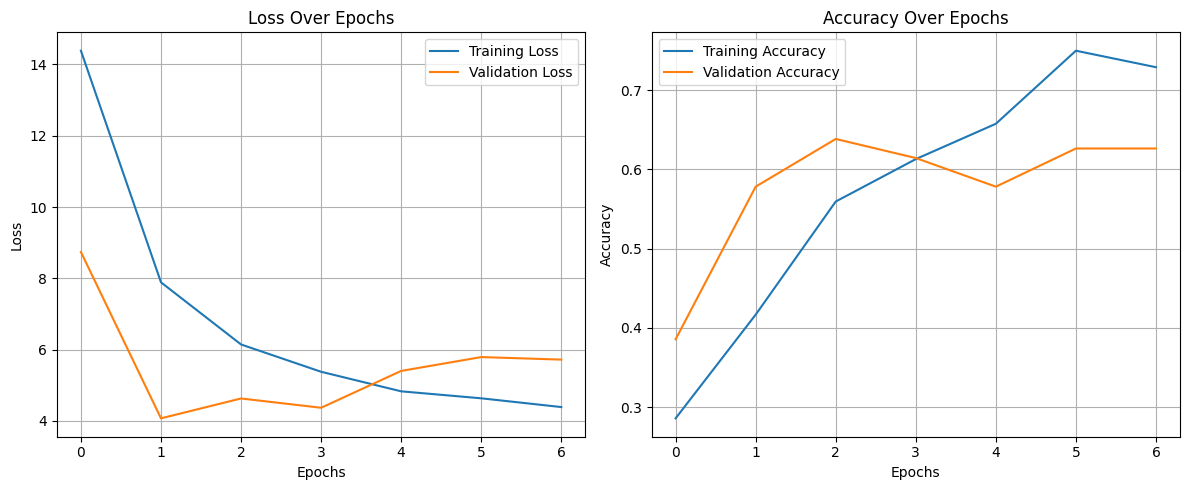

In [41]:
# Train the model and save the history
  # Adjust epochs as needed

# Plot the loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot the accuracy values
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()  # Adjusts the layout
plt.show()



Path of the image to be predicted: /content/APPLE_DISEASE_DATASET/LEAF BLOTCH/5096.jpg.jpeg


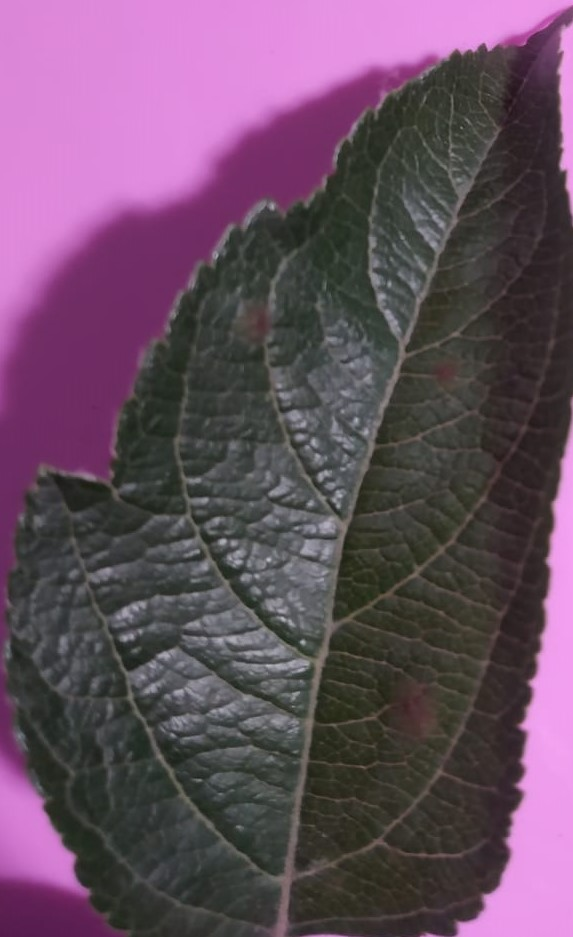

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[1.7113365e-04 1.3115341e-10 9.9982882e-01 5.8851175e-12]]
Predicted class label: Leaf Blotch
The leaf has Leaf Blotch.


In [52]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Use this for displaying images in Colab

# Get the path of the image to be predicted
input_image_path = input('Path of the image to be predicted: ')

# Read the input image
input_image = cv2.imread(input_image_path)

# Display the image
cv2_imshow(input_image)

# Resize the image to the input size of the model
input_image_resized = cv2.resize(input_image, (224, 224))

# Scale pixel values to [0, 1]
input_image_scaled = input_image_resized / 255.0

# Reshape the image to match the input shape of the model
input_image_reshaped = np.reshape(input_image_scaled, [1, 224, 224, 3])

# Make predictions
input_prediction = model.predict(input_image_reshaped)

# Print prediction results
print(input_prediction)

# Get the predicted class label
input_pred_label = np.argmax(input_prediction)

# Define class labels
class_labels = ["Apple Rot Leaves", "Healthy Leaves", "Leaf Blotch", "Scab Leaves"]

# Print the predicted class label
print(f"Predicted class label: {class_labels[input_pred_label]}")

# Interpretation of the prediction
if input_pred_label == 1:
    print("The leaf is healthy.")
elif input_pred_label == 0:
    print("The leaf has Apple Rot.")
elif input_pred_label == 2:
    print("The leaf has Leaf Blotch.")
elif input_pred_label == 3:
    print("The leaf has Scab.")
else:
    print("Unknown prediction.")